✅ Project path set to: C:\Users\DELL\Documents\chem_bms_optimizer_v3
USING optimizer from:       C:\Users\DELL\Documents\chem_bms_optimizer_v3\optimizer.py
USING run_all_methods from: C:\Users\DELL\Documents\chem_bms_optimizer_v3\run_all_methods.py

=== Mid-Bound Sanity Check (ChemCost=1−S) ===
EV   :  S=0.785  ChemCost(1−S)=0.215  BMS=0.420  Pen=1.131
BESS :  S=0.827  ChemCost(1−S)=0.173  BMS=0.360  Pen=1.125
SESS :  S=0.799  ChemCost(1−S)=0.201  BMS=0.340  Pen=1.125

=== Running run_all_methods.py ===

[INFO] Enabled methods: ['Steepest Descent', 'Quasi-Newton (BFGS)', "Newton's Method", 'Line Search (Golden)', 'SQP (KKT)'] Application Method Best Chemistry Total J Suitability (S) Chem Cost (1-S) BMS Term Penalty Term Iter Converged Stop Reason Time (s) BESS Newton's Method LFP 0.196640 0.8270 0.1730 0.006222 0.017419 193 True rel_delta_J<=0.0005 166.114131 BESS Quasi-Newton (BFGS) Na-ion 0.236891 0.7695 0.2305 0.006391 0.000000 11 True rel_delta_J<=0.0005 35.922974 BESS Line Search 

Application,Method,Best Chemistry,Total J,Suitability (S),Chem Cost (1-S),BMS Term,Penalty Term,Iter,Converged,Stop Reason,Time (s)
BESS,Newton's Method,LFP,0.197,0.827,0.173,0.006,0.017,193,True,rel_delta_J<=0.0005,166.11
BESS,Quasi-Newton (BFGS),Na-ion,0.237,0.770,0.230,0.006,0.000,11,True,rel_delta_J<=0.0005,35.92
BESS,Line Search (Golden),LFP,0.330,0.827,0.173,0.157,0.000,41,True,rel_delta_J<=0.0005,31.26
BESS,SQP (KKT),LFP,0.356,0.827,0.173,0.183,0.000,10,True,rel_delta_J<=0.0005,4.44
BESS,Steepest Descent,LFP,0.366,0.827,0.173,0.193,0.000,40,True,rel_delta_J<=1e-05,24.92
EV,Quasi-Newton (BFGS),SCiB,0.231,0.774,0.226,0.005,0.000,11,True,rel_delta_J<=0.0005,40.13
EV,Newton's Method,LFP,0.239,0.785,0.215,0.005,0.019,192,True,rel_delta_J<=0.0005,128.67
EV,Line Search (Golden),LFP,0.381,0.785,0.215,0.166,0.000,41,True,rel_delta_J<=0.0005,18.95
EV,Steepest Descent,LFP,0.416,0.785,0.215,0.201,0.000,44,True,rel_delta_J<=1e-05,27.92
EV,SQP (KKT),SCiB,0.417,0.774,0.226,0.190,0.000,10,True,rel_delta_J<=0.0005,5.20


✅ Saved:
 - C:\Users\DELL\Documents\chem_bms_optimizer_v3\outputs\summary_methods_3dp.csv
 - C:\Users\DELL\Documents\chem_bms_optimizer_v3\outputs\summary_methods_3dp.md

=== Winners by Application (J↓ cost, S↑ suitability) ===
Application              Method Best Chemistry  Total J  Suitability (S)  Iter  Time (s)
       BESS     Newton's Method            LFP    0.197            0.827   193   166.110
         EV Quasi-Newton (BFGS)           SCiB    0.231            0.774    11    40.130
       SESS     Newton's Method            LFP    0.225            0.799   193   195.230


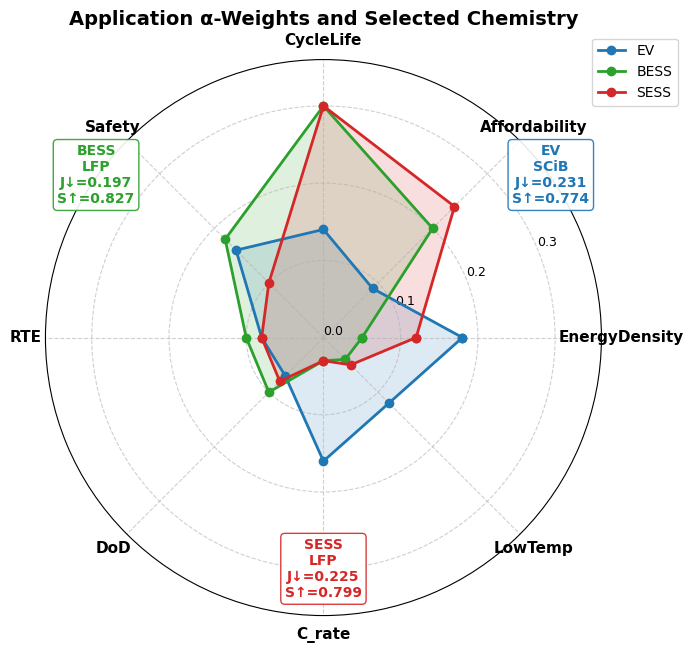

In [16]:
# ============================================================
#  BMS CHEMISTRY OPTIMIZER – FULL NOTEBOOK DRIVER (AUTO-PATH)
#  Works with optimizer.py and run_all_methods.py
#  ✓ Uses Suitability S and Chem Cost (1−S)
#  ✓ Saves summary with 3 d.p. (and 2 d.p. for time)
#  ✓ Radar chart annotates J↓ and S↑ for winners
# ============================================================

from pathlib import Path
import sys, importlib, subprocess, textwrap, os
import numpy as np
import pandas as pd
from IPython.display import display

# ------------------------------------------------------------
# Auto-detect project root (works in Jupyter and .py)
# ------------------------------------------------------------
def detect_project_root(markers=("sample_data", "optimizer.py", "run_all_methods.py"),
                        max_levels=8):
    """Walk upward from CWD (Jupyter) or script dir (.py) until a marker is found."""
    if "__file__" in globals():
        start = Path(__file__).resolve().parent
    else:
        start = Path(os.getcwd()).resolve()

    p = start
    for _ in range(max_levels):
        if any((p / m).exists() for m in markers):
            return p
        if p.parent == p:
            break
        p = p.parent
    raise FileNotFoundError(
        f"Could not locate project root from {start}. "
        f"Looked for markers: {markers}"
    )

PROJECT = detect_project_root()
sys.path.insert(0, str(PROJECT))
assert (PROJECT / "sample_data").exists(), f"❌ sample_data folder not found in {PROJECT}"
print(f"✅ Project path set to: {PROJECT}")

# ------------------------------------------------------------
# Imports from project
# ------------------------------------------------------------
optimizer = importlib.import_module("optimizer")
run_all_methods = importlib.import_module("run_all_methods")
print("USING optimizer from:      ", optimizer.__file__)
print("USING run_all_methods from:", run_all_methods.__file__)

# ============================================================
# 3.  SANITY CHECK: mid-bound J decomposition
# ============================================================
from run_all_methods import make_repo_for_app
repo0 = optimizer.load_repo(PROJECT)

print("\n=== Mid-Bound Sanity Check (ChemCost=1−S) ===")
for app in ["EV", "BESS", "SESS"]:
    repo = make_repo_for_app(repo0, app)
    lo = repo.bms_bounds["lo"].to_numpy()
    hi = repo.bms_bounds["hi"].to_numpy()
    p0 = (lo + hi) / 2
    x0 = np.zeros(len(repo.P)); x0[0] = 1.0
    J, parts = optimizer.J_objective(app, x0, p0, repo)
    chem_cost = parts.get("chem_term", np.nan)           # this is 1−S in updated optimizer.py
    S = parts.get("suitability", 1.0 - chem_cost)        # back-compute if needed
    print(f"{app:5s}:  S={S:.3f}  ChemCost(1−S)={chem_cost:.3f}  BMS={parts['bms_term']:.3f}  Pen={parts['pen_term']:.3f}")

# ============================================================
# 4.  RUN OPTIMIZATION METHODS (all five)
# ============================================================
print("\n=== Running run_all_methods.py ===\n")
res = subprocess.run(
    [sys.executable, str(PROJECT / "run_all_methods.py")],
    capture_output=True, text=True, cwd=str(PROJECT)
)
if res.returncode != 0:
    print("❌ run_all_methods.py exited with an error:\n", res.stderr)
else:
    print(textwrap.shorten(res.stdout, width=4000, placeholder="..."))
    print("✅ run_all_methods.py completed successfully\n")

# ============================================================
# 5.  LOAD AND SHOW RESULTS SUMMARY
# ============================================================
# ==== Paths ====
src_csv = PROJECT / "outputs" / "summary_methods.csv"
dst_csv = PROJECT / "outputs" / "summary_methods_3dp.csv"
dst_md  = PROJECT / "outputs" / "summary_methods_3dp.md"

# ==== Load ====
df = pd.read_csv(src_csv)

# ==== Normalize column names depending on your script version ====
# Preferred new columns:
col_S       = "Suitability (S)"
col_CHEMC   = "Chem Cost (1-S)"
# Back-compat:
if col_S not in df.columns and "Suitability" in df.columns:
    df.rename(columns={"Suitability": col_S}, inplace=True)
if col_CHEMC not in df.columns:
    # Old name was "Chem Term" which used to be S; now optimizer returns chem_term=1−S
    if "Chem Term" in df.columns and "Suitability (S)" in df.columns:
        df.rename(columns={"Chem Term": col_CHEMC}, inplace=True)
    elif "Chem Term" in df.columns and "Suitability (S)" not in df.columns:
        # Assume Chem Term is already 1−S; reconstruct S
        df[col_CHEMC] = df["Chem Term"].astype(float)
        df[col_S] = 1.0 - df[col_CHEMC]
    elif "Chem Cost (1-S)" in df.columns:
        pass  # already correct

# ==== Order + select ====
cols_order = [
    "Application","Method","Best Chemistry",
    "Total J", col_S, col_CHEMC, "BMS Term","Penalty Term",
    "Iter","Converged","Stop Reason","Time (s)"
]
# keep only existing ones in that order
cols_order = [c for c in cols_order if c in df.columns]
df = df[cols_order].copy()

# ==== Round for presentation ====
three_dp = ["Total J", col_S, col_CHEMC, "BMS Term", "Penalty Term"]
two_dp   = ["Time (s)"]

for c in three_dp:
    if c in df.columns: df[c] = df[c].astype(float).round(3)
for c in two_dp:
    if c in df.columns: df[c] = df[c].astype(float).round(2)

# Avoid scientific notation in cells like 0.000
pd.options.display.float_format = "{:,.3f}".format

# ==== Pretty display in notebook ====
styled = (df.style
          .hide(axis="index")
          .set_caption("Summary (3-decimal formatting; J↓ cost, S↑ suitability)")
          .format({**{c:"{:.3f}" for c in three_dp if c in df.columns},
                   **{c:"{:.2f}" for c in two_dp if c in df.columns}})
          .set_table_styles([
              {"selector":"caption","props":[("caption-side","top"),
                                             ("font-weight","bold"),
                                             ("font-size","14px"),
                                             ("padding","6px 0")]}
          ]))
display(styled)

# ==== Save a rounded CSV (values kept at 3dp / 2dp) ====
df_out = df.copy()
for c in three_dp:
    if c in df_out.columns:
        df_out[c] = df_out[c].map(lambda v: f"{float(v):.3f}")
for c in two_dp:
    if c in df_out.columns:
        df_out[c] = df_out[c].map(lambda v: f"{float(v):.2f}")
df_out.to_csv(dst_csv, index=False, encoding="utf-8")

# Markdown export (optional; requires 'tabulate')
try:
    df_out.to_markdown(dst_md, index=False)
    print("✅ Saved:")
    print(" -", dst_csv)
    print(" -", dst_md)
except Exception as e:
    print("✅ Saved:", dst_csv)
    print("ℹ️ Skipped Markdown export (install `tabulate` to enable). Reason:", e)

# Winners per application
group_key = "Application"
if group_key in df.columns and "Total J" in df.columns:
    winners = (
        df.loc[df.groupby(group_key)["Total J"].idxmin(),
               [c for c in ["Application","Method","Best Chemistry","Total J", col_S, "Iter","Time (s)"] if c in df.columns]]
          .sort_values("Application")
    )
    print("\n=== Winners by Application (J↓ cost, S↑ suitability) ===")
    print(winners.to_string(index=False))
else:
    print("\n⚠️ Could not compute winners (missing columns).")

# ============================================================
# 6.  RADAR PLOT – α-weights vs Selected Chemistry (annotate J↓ & S↑)
# ============================================================
import matplotlib.pyplot as plt

alpha = pd.read_csv(PROJECT / "sample_data" / "alpha_weights.csv")
summary = pd.read_csv(PROJECT / "outputs" / "summary_methods.csv")

# Radar chart setup
apps = ["EV", "BESS", "SESS"]
metrics = alpha["metric"].tolist()
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

colors = ["#1f77b4", "#2ca02c", "#d62728"]   # EV, BESS, SESS colors
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

# Plot α-weight polygons
for app, color in zip(apps, colors):
    vals = alpha[app].tolist() + [alpha[app].tolist()[0]]
    ax.plot(angles, vals, marker='o', linewidth=2, label=app, color=color)
    ax.fill(angles, vals, alpha=0.15, color=color)

# Ensure we have S and J columns in 'summary'
if col_S not in summary.columns and "Suitability" in summary.columns:
    summary.rename(columns={"Suitability": col_S}, inplace=True)
if "Chem Cost (1-S)" not in summary.columns and "Chem Term" in summary.columns and col_S in summary.columns:
    summary["Chem Cost (1-S)"] = 1.0 - summary[col_S]

# Annotate best chemistry for each application with J↓ and S↑
winners2 = (summary
            .loc[summary.groupby("Application")["Total J"].idxmin(),
                 [c for c in ["Application","Best Chemistry","Total J", col_S] if c in summary.columns]]
            .reset_index(drop=True))

radius = 0.34  # annotation radius just outside the radar
for i, (app, color) in enumerate(zip(apps, colors)):
    row = winners2[winners2["Application"] == app]
    if row.empty:
        continue
    chem = row["Best Chemistry"].values[0]
    Jval = float(row["Total J"].values[0])
    Sval = float(row[col_S].values[0]) if col_S in row.columns else float('nan')
    angle = np.deg2rad(30 + i * 120)  # 45°, 165°, 285°
    ax.text(angle, radius,
            f"{app}\n{chem}\nJ↓={Jval:.3f}\nS↑={Sval:.3f}",
            ha="center", va="bottom",
            fontsize=10, fontweight="bold",
            color=color,
            bbox=dict(facecolor="white",
                      alpha=0.9,
                      edgecolor=color,
                      boxstyle="round,pad=0.3"))

# Styling
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=11, fontweight="bold")
ax.set_yticks(np.linspace(0, 0.3, 4))
ax.set_yticklabels(["0.0", "0.1", "0.2", "0.3"], fontsize=9)
ax.set_ylim(0, 0.36)
ax.set_title("Application α-Weights and Selected Chemistry",
             size=14, pad=25, fontweight="bold")
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1.05), frameon=True)
plt.tight_layout()
plt.show()
